In [1]:
import random
import numpy as np
import pandas as pd
from pulp import LpMaximize, LpProblem, LpVariable

# For plotting
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# -----------------------------
# 1. Generate Synthetic SMB Customer Data (Refined)
# -----------------------------
NUM_CUSTOMERS = 600
MAX_VISITS_PER_CUSTOMER = 5
TOTAL_VISITS_BUDGET = 1200
COST_PER_VISIT = 150
REVENUE_PER_CONVERSION = 3000

random.seed(42)

customer_data = []
for i in range(NUM_CUSTOMERS):
    # baseline potential
    base_potential = random.uniform(0.05, 0.25)          
    # how strongly they respond to additional visits
    sensitivity = random.uniform(0.10, 0.30)            
    # how quickly additional visits' effect tapers
    diminishing_factor = random.uniform(0.7, 0.95)      

    # Also imagine some "customer size" or "segment" that influences revenue or cost
    # We'll keep revenue uniform for simplicity, but you could modulate it by segment if desired.
    customer_data.append({
        'customer_id': i,
        'base_potential': base_potential,
        'sensitivity': sensitivity,
        'diminishing_factor': diminishing_factor
    })

df_customers = pd.DataFrame(customer_data)

def expected_conversion_prob(base, sensitivity, diminishing_factor, visits):
    """A toy function modeling conversion probability given a certain number of visits."""
    prob = base
    for v in range(visits):
        prob += sensitivity * (diminishing_factor ** v)
    return min(prob, 1.0)

# Precompute probabilities for 0..MAX_VISITS for each customer
prob_matrix = {}
for i, row in df_customers.iterrows():
    prob_matrix[i] = []
    for v in range(MAX_VISITS_PER_CUSTOMER + 1):
        prob_matrix[i].append(
            expected_conversion_prob(
                row['base_potential'],
                row['sensitivity'],
                row['diminishing_factor'],
                v
            )
        )

# ---------------------------------------------
# 2. "Optimal" Allocation (Greedy Heuristic)
# ---------------------------------------------
df_customers['assigned_visits'] = 0
assigned_visits = [0]*NUM_CUSTOMERS
remaining_visits = TOTAL_VISITS_BUDGET

while remaining_visits > 0:
    best_customer = None
    best_gain = 0.0
    for i in range(NUM_CUSTOMERS):
        current_visits = assigned_visits[i]
        if current_visits < MAX_VISITS_PER_CUSTOMER:
            current_prob = prob_matrix[i][current_visits]
            next_prob = prob_matrix[i][current_visits+1]
            marginal_gain = next_prob - current_prob
            if marginal_gain > best_gain:
                best_gain = marginal_gain
                best_customer = i
    if best_customer is None:
        break
    assigned_visits[best_customer] += 1
    remaining_visits -= 1

df_customers['assigned_visits'] = assigned_visits
df_customers['optimal_expected_conversion'] = [
    prob_matrix[i][assigned_visits[i]] for i in range(NUM_CUSTOMERS)
]

# -----------------------------
# 3. Real-World (Actual) Visits
# -----------------------------
# Some deviate from assigned visits. We'll define a random mechanism:
actual_visits = []
for i in range(NUM_CUSTOMERS):
    opt_vis = assigned_visits[i]
    draw = random.random()
    if draw < 0.5:
        # ~50% chance: stick to optimal
        v = opt_vis
    elif draw < 0.75:
        # ~25% chance: 1 less (if possible)
        v = max(opt_vis - 1, 0)
    else:
        # ~25% chance: 1 more (if possible)
        v = min(opt_vis + 1, MAX_VISITS_PER_CUSTOMER)
    actual_visits.append(v)

df_customers['actual_visits'] = actual_visits
df_customers['actual_conversion_prob'] = [
    prob_matrix[i][actual_visits[i]] for i in range(NUM_CUSTOMERS)
]

# Now let's do an actual realization (Bernoulli draw)
df_customers['actual_conversion'] = [
    1 if random.random() < df_customers.loc[i, 'actual_conversion_prob'] else 0
    for i in range(NUM_CUSTOMERS)
]

# Comparison group
def compare_visits(row):
    if row['actual_visits'] < row['assigned_visits']:
        return 'Less'
    elif row['actual_visits'] == row['assigned_visits']:
        return 'Equal'
    else:
        return 'More'

df_customers['visit_comparison_group'] = df_customers.apply(compare_visits, axis=1)

# Compute Cost and Revenue
df_customers['cost_actual'] = df_customers['actual_visits'] * COST_PER_VISIT
df_customers['revenue_actual'] = df_customers['actual_conversion'] * REVENUE_PER_CONVERSION
df_customers['profit_actual'] = df_customers['revenue_actual'] - df_customers['cost_actual']

# For "optimal" scenario (counterfactual), we can do:
df_customers['cost_optimal'] = df_customers['assigned_visits'] * COST_PER_VISIT
# We'll use the model's predicted probability as expected conversion
df_customers['expected_revenue_optimal'] = df_customers['optimal_expected_conversion'] * REVENUE_PER_CONVERSION
df_customers['expected_profit_optimal'] = df_customers['expected_revenue_optimal'] - df_customers['cost_optimal']


In [2]:
def safe_roi(profit, cost):
    if cost == 0:
        # If cost is zero, define ROI = 0 or do something custom
        return 0
    else:
        return profit / cost

df_customers['roi_actual'] = df_customers.apply(
    lambda row: safe_roi(row['profit_actual'], row['cost_actual']), axis=1
)

df_customers['roi_optimal'] = df_customers.apply(
    lambda row: safe_roi(row['expected_profit_optimal'], row['cost_optimal']), axis=1
)


In [3]:
grouped_roi = df_customers.groupby('visit_comparison_group').agg({
    'roi_actual': 'mean',
    'roi_optimal': 'mean'
}).reset_index()

print(grouped_roi)


  visit_comparison_group  roi_actual  roi_optimal
0                  Equal    3.769154     3.297393
1                   Less    3.764368     4.434329
2                   More    3.351230     3.149383


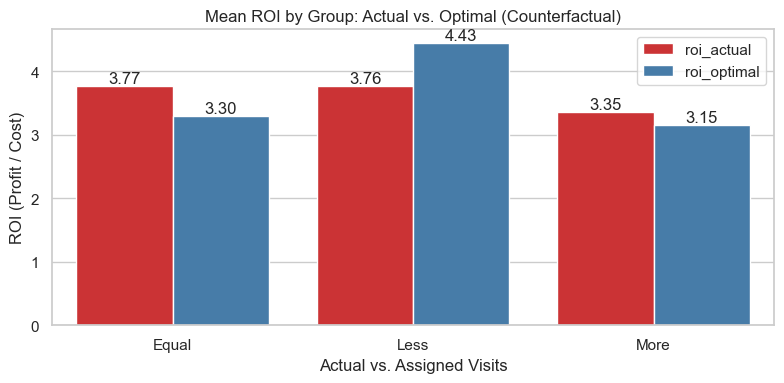

In [4]:
plt.figure(figsize=(8,4))
melted = grouped_roi.melt(id_vars='visit_comparison_group', 
                          value_vars=['roi_actual','roi_optimal'], 
                          var_name='ROI_Type', value_name='ROI_Value')

ax = sns.barplot(x='visit_comparison_group', y='ROI_Value', hue='ROI_Type', data=melted, palette='Set1')
ax.set_title("Mean ROI by Group: Actual vs. Optimal (Counterfactual)")
ax.set_xlabel("Actual vs. Assigned Visits")
ax.set_ylabel("ROI (Profit / Cost)")

# Annotate bars
for c in ax.containers:
    ax.bar_label(c, fmt="%.2f")

plt.legend(title='')
plt.tight_layout()
plt.show()


In [6]:
df_customers['treated'] = df_customers.apply(
    lambda row: 1 if row['actual_visits'] == row['assigned_visits'] else 0, axis=1
)

# Let's define some baseline covariates for the propensity model
covariates = ['base_potential', 'sensitivity', 'diminishing_factor']

# We'll do a quick logistic regression to get a propensity score (the probability of being 'treated')
import statsmodels.api as sm

X = df_customers[covariates]
X = sm.add_constant(X)
y = df_customers['treated']

logit_model = sm.Logit(y, X).fit(disp=False)
df_customers['propensity'] = logit_model.predict(X)


In [7]:
treated_df = df_customers[df_customers['treated'] == 1].copy()
control_df = df_customers[df_customers['treated'] == 0].copy()

treated_scores = treated_df['propensity'].values
control_scores = control_df['propensity'].values

# We'll store matches as (treated_idx, control_idx)
matches = []
used_control = set()

for idx, score in zip(treated_df.index, treated_scores):
    # Find control with closest propensity
    diffs = np.abs(control_scores - score)
    best_idx = np.argmin(diffs)
    control_idx = control_df.index[best_idx]
    if control_idx not in used_control:
        matches.append((idx, control_idx))
        used_control.add(control_idx)

matched_pairs = pd.DataFrame(matches, columns=['treated_idx','control_idx'])
print(f"Total matched pairs: {len(matched_pairs)}")


Total matched pairs: 170


In [8]:
treated_values = []
control_values = []

for _, row in matched_pairs.iterrows():
    t_idx = row['treated_idx']
    c_idx = row['control_idx']
    treated_values.append(df_customers.loc[t_idx, 'roi_actual'])
    control_values.append(df_customers.loc[c_idx, 'roi_actual'])

matched_df = pd.DataFrame({
    'treated_roi': treated_values,
    'control_roi': control_values
})
matched_df['diff'] = matched_df['treated_roi'] - matched_df['control_roi']

avg_effect = matched_df['diff'].mean()
print(f"Average Treatment Effect on the Treated (ATT) in terms of ROI: {avg_effect:.3f}")


Average Treatment Effect on the Treated (ATT) in terms of ROI: 0.357


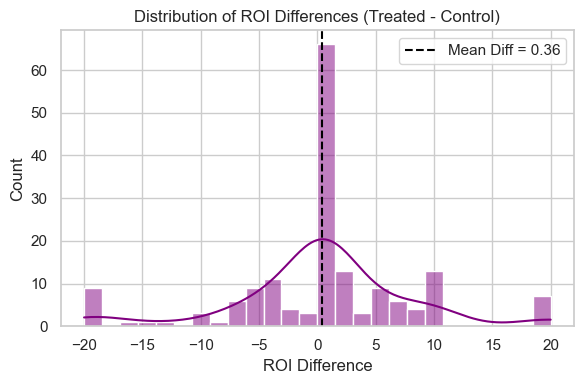

In [9]:
plt.figure(figsize=(6,4))
sns.histplot(matched_df['diff'], kde=True, color='purple')
plt.axvline(matched_df['diff'].mean(), color='black', linestyle='--', label=f"Mean Diff = {avg_effect:.2f}")
plt.title("Distribution of ROI Differences (Treated - Control)")
plt.xlabel("ROI Difference")
plt.legend()
plt.tight_layout()
plt.show()


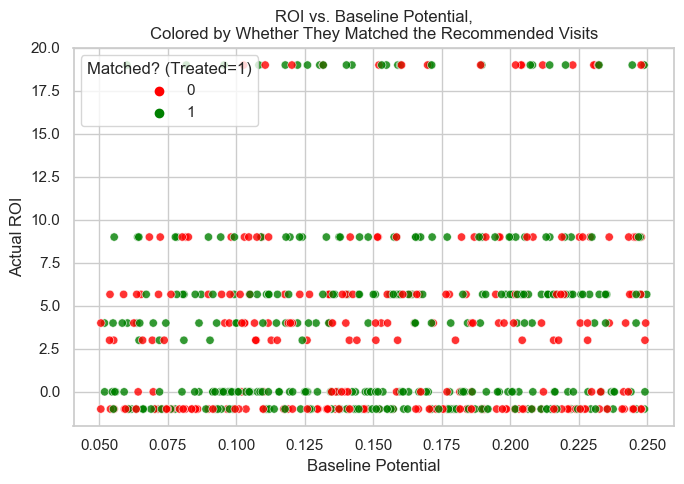

In [10]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    x='base_potential', 
    y='roi_actual', 
    hue='treated', 
    data=df_customers, 
    alpha=0.8, 
    palette=['red','green']
)
plt.title("ROI vs. Baseline Potential,\nColored by Whether They Matched the Recommended Visits")
plt.xlabel("Baseline Potential")
plt.ylabel("Actual ROI")
plt.legend(title='Matched? (Treated=1)')
plt.tight_layout()
plt.show()


In [11]:
def safe_div(num, denom):
    return num / denom if denom != 0 else 0

def population_roi_actual(df):
    total_profit = df['profit_actual'].sum()
    total_cost = df['cost_actual'].sum()
    return safe_div(total_profit, total_cost)

def population_roi_counterfactual(df):
    total_profit = df['expected_profit_optimal'].sum()
    total_cost = df['cost_optimal'].sum()
    return safe_div(total_profit, total_cost)


In [12]:
roi_actual_full = population_roi_actual(df_customers)
roi_cf_full = population_roi_counterfactual(df_customers)

print(f"Population ROI (Actual): {roi_actual_full:.3f}")
print(f"Population ROI (Counterfactual): {roi_cf_full:.3f}")

difference_full = roi_cf_full - roi_actual_full
print(f"Difference (CF - Actual): {difference_full:.3f}")


Population ROI (Actual): 4.191
Population ROI (Counterfactual): 4.544
Difference (CF - Actual): 0.353


In [13]:
B = 2000
differences = []
ratios = []

n = len(df_customers)

for _ in range(B):
    # sample indices with replacement
    sample_indices = np.random.choice(df_customers.index, size=n, replace=True)
    df_sample = df_customers.loc[sample_indices]

    roi_actual_sample = population_roi_actual(df_sample)
    roi_cf_sample = population_roi_counterfactual(df_sample)

    # difference
    diff = roi_cf_sample - roi_actual_sample
    differences.append(diff)

    # ratio
    ratio = safe_div(roi_cf_sample, roi_actual_sample)
    ratios.append(ratio)

# Compute percentiles
diff_lower = np.percentile(differences, 2.5)
diff_upper = np.percentile(differences, 97.5)
diff_mean = np.mean(differences)

ratio_lower = np.percentile(ratios, 2.5)
ratio_upper = np.percentile(ratios, 97.5)
ratio_mean = np.mean(ratios)

print(f"Bootstrap 95% CI for (CF ROI - Actual ROI): [{diff_lower:.3f}, {diff_upper:.3f}]")
print(f"Mean Difference: {diff_mean:.3f}")

print(f"Bootstrap 95% CI for (CF ROI / Actual ROI): [{ratio_lower:.3f}, {ratio_upper:.3f}]")
print(f"Mean Ratio: {ratio_mean:.3f}")


Bootstrap 95% CI for (CF ROI - Actual ROI): [0.022, 0.676]
Mean Difference: 0.352
Bootstrap 95% CI for (CF ROI / Actual ROI): [1.005, 1.174]
Mean Ratio: 1.086


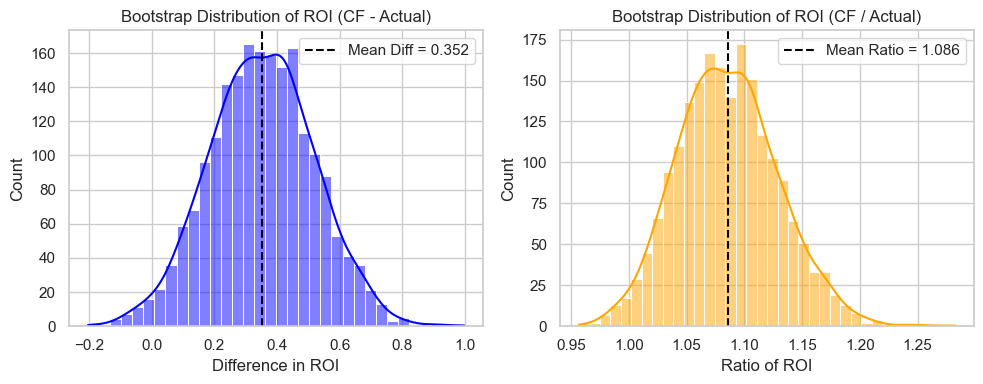

In [14]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.histplot(differences, kde=True, color='blue')
plt.axvline(diff_mean, color='black', linestyle='--', label=f"Mean Diff = {diff_mean:.3f}")
plt.title("Bootstrap Distribution of ROI (CF - Actual)")
plt.xlabel("Difference in ROI")
plt.legend()

plt.subplot(1,2,2)
sns.histplot(ratios, kde=True, color='orange')
plt.axvline(ratio_mean, color='black', linestyle='--', label=f"Mean Ratio = {ratio_mean:.3f}")
plt.title("Bootstrap Distribution of ROI (CF / Actual)")
plt.xlabel("Ratio of ROI")
plt.legend()

plt.tight_layout()
plt.show()



Logistic Regression for Adherence (treated=1):
                            Logit Regression Results                           
Dep. Variable:                treated   No. Observations:                   60
Model:                          Logit   Df Residuals:                       51
Method:                           MLE   Df Model:                            8
Date:                Tue, 31 Dec 2024   Pseudo R-squ.:                 0.04134
Time:                        15:32:52   Log-Likelihood:                -39.838
converged:                       True   LL-Null:                       -41.555
Covariance Type:            nonrobust   LLR p-value:                    0.9041
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.4610      3.490     -0.132      0.895      -7.302       6.380
C(territory)[T.North]    -0.5375      0.776     -

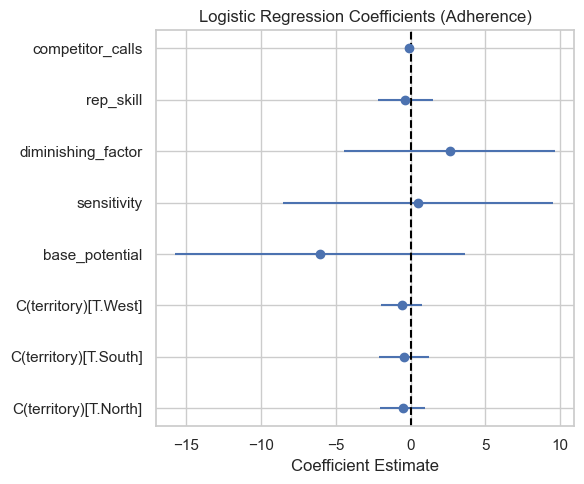

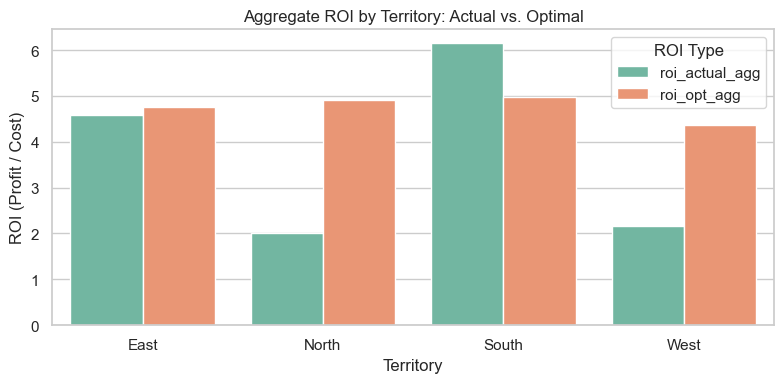


Implementation Feasibility: sample recommended vs actual visits in each territory

   customer_id territory  assigned_visits  actual_visits  treated
0            0      West                0              1        0
1            1      East                0              0        1
2            2     South                0              0        1
3            3     South                0              0        1
4            4      East                1              2        0
5            5      East                2              1        0
6            6     North                3              2        0
7            7      East                2              2        1
8            8     North                2              1        0
9            9      West                2              1        0


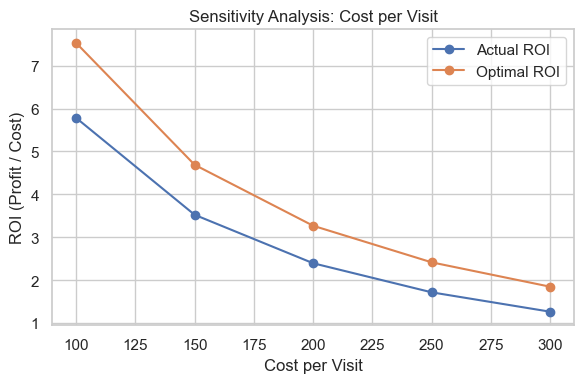

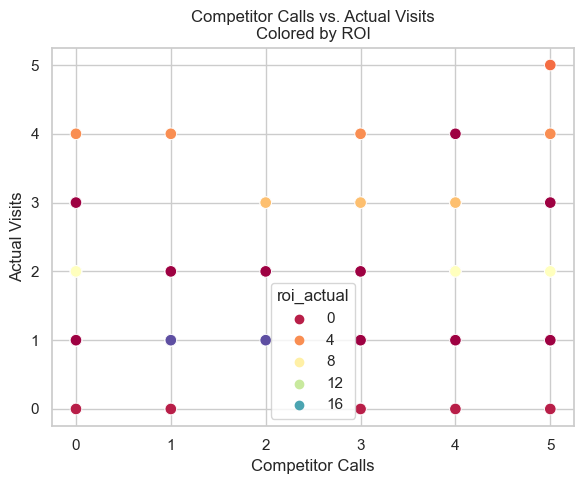


Bootstrap CI for (Optimal ROI - Actual ROI): [0.028, 2.257]
Mean Difference: 1.140 vs. Observed Diff: 1.166


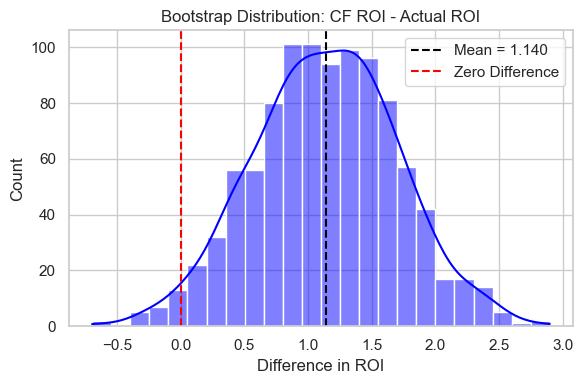


Compliance Violations in Assigned Visits: 0 (should be 0 if code is correct)


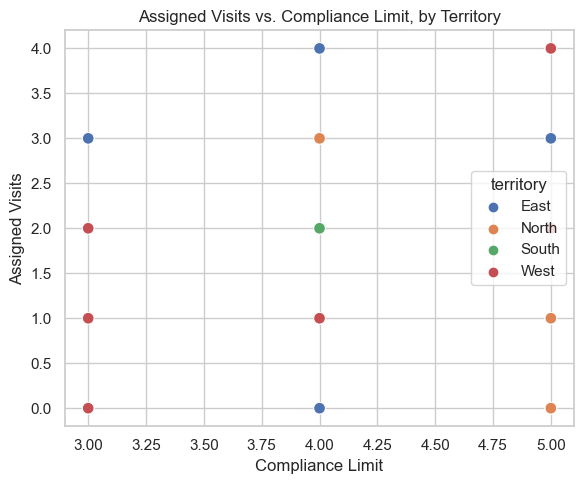

In [15]:
import random
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
random.seed(42)

###############################################################################
# 0. CONFIG & HELPER FUNCTIONS
###############################################################################
# Let's define some constants and simple helper functions

NUM_CUSTOMERS = 60
MAX_VISITS_PER_CUSTOMER = 5
TOTAL_VISITS_BUDGET = 120

COST_PER_VISIT = 150          # baseline cost per visit
REVENUE_PER_CONVERSION = 3000

# We'll create a simple function for safe division (to avoid dividing by zero).
def safe_div(num, denom):
    return num / denom if denom != 0 else 0

def expected_conversion_prob(base, sensitivity, diminishing_factor, visits):
    """A toy function modeling conversion probability given a certain number of visits."""
    prob = base
    for v in range(visits):
        prob += sensitivity * (diminishing_factor ** v)
    return min(prob, 1.0)

###############################################################################
# 1. DATA GENERATION
###############################################################################
# We'll add:
#   - territory (categorical)
#   - rep_skill (continuous)
#   - competitor_calls (int)
#   - compliance_limit (int) maximum allowed calls by regulation/policy

territories = ['East', 'West', 'North', 'South']
customer_data = []

for i in range(NUM_CUSTOMERS):
    base_potential = random.uniform(0.05, 0.25)
    sensitivity = random.uniform(0.10, 0.30)
    diminishing_factor = random.uniform(0.7, 0.95)
    
    # Assign territory randomly
    territory = random.choice(territories)
    
    # Rep skill: float between 0.5 and 1.5, random
    rep_skill = random.uniform(0.5, 1.5)
    
    # Competitor calls: random integer 0..5
    competitor_calls = random.randint(0, 5)
    
    # compliance_limit: we can set it between 3..5 or so
    compliance_limit = random.randint(3, 5)
    
    customer_data.append({
        'customer_id': i,
        'base_potential': base_potential,
        'sensitivity': sensitivity,
        'diminishing_factor': diminishing_factor,
        'territory': territory,
        'rep_skill': rep_skill,
        'competitor_calls': competitor_calls,
        'compliance_limit': compliance_limit
    })

df_customers = pd.DataFrame(customer_data)

# Because rep skill might amplify or reduce the final conversion probability,
# we can incorporate it into the probability function. Let's define
# an "effective" visits function:
def adjusted_conversion_prob(row, visits):
    # incorporate rep_skill by boosting "sensitivity" a bit
    # For example, if rep_skill > 1, we get slightly better effect, etc.
    skill_factor = row['rep_skill']
    base = row['base_potential']
    sens = row['sensitivity'] * skill_factor
    dim = row['diminishing_factor']
    return expected_conversion_prob(base, sens, dim, visits)

# Precompute probability for 0..MAX_VISITS, but also ensure visits <= compliance_limit
prob_matrix = {}
for i, row in df_customers.iterrows():
    prob_matrix[i] = []
    for v in range(MAX_VISITS_PER_CUSTOMER + 1):
        if v <= row['compliance_limit']:
            prob_matrix[i].append(adjusted_conversion_prob(row, v))
        else:
            # If it exceeds compliance, treat prob as identical to compliance_limit visits
            # or we could treat it as invalid, but let's clamp it:
            prob_matrix[i].append(adjusted_conversion_prob(row, row['compliance_limit']))

# 1.2. Simple Constrained "Greedy" Allocation (Optimal Recommendation) 
# We'll also ensure we don't exceed each customer's compliance_limit.
assigned_visits = [0]*NUM_CUSTOMERS
remaining_visits = TOTAL_VISITS_BUDGET

while remaining_visits > 0:
    best_customer = None
    best_gain = 0.0
    for idx in range(NUM_CUSTOMERS):
        current_visits = assigned_visits[idx]
        # don't exceed compliance limit or max visits
        if current_visits < df_customers.loc[idx, 'compliance_limit'] and current_visits < MAX_VISITS_PER_CUSTOMER:
            current_prob = prob_matrix[idx][current_visits]
            next_prob = prob_matrix[idx][current_visits+1]
            marginal_gain = next_prob - current_prob
            if marginal_gain > best_gain:
                best_gain = marginal_gain
                best_customer = idx
    if best_customer is None:
        break
    assigned_visits[best_customer] += 1
    remaining_visits -= 1

df_customers['assigned_visits'] = assigned_visits
df_customers['optimal_expected_conversion'] = [
    prob_matrix[i][assigned_visits[i]] for i in range(NUM_CUSTOMERS)
]

# 1.3. Actual Visits with Random Deviation
actual_visits = []
for i in range(NUM_CUSTOMERS):
    opt_vis = assigned_visits[i]
    draw = random.random()
    if draw < 0.5:
        # ~50% chance: stick to optimal
        v = opt_vis
    elif draw < 0.75:
        # ~25% chance: 1 less (if possible)
        v = max(opt_vis - 1, 0)
    else:
        # ~25% chance: 1 more (if possible, but don't exceed compliance)
        v = min(opt_vis + 1, df_customers.loc[i, 'compliance_limit'])
    actual_visits.append(v)

df_customers['actual_visits'] = actual_visits

# 1.4 Realized Probability + Conversion
df_customers['actual_conversion_prob'] = [
    prob_matrix[i][df_customers.loc[i, 'actual_visits']] for i in range(NUM_CUSTOMERS)
]

df_customers['actual_conversion'] = [
    1 if random.random() < p else 0 for p in df_customers['actual_conversion_prob']
]

# 1.5 Cost & Revenue
df_customers['cost_optimal'] = df_customers['assigned_visits'] * COST_PER_VISIT
df_customers['expected_revenue_optimal'] = df_customers['optimal_expected_conversion'] * REVENUE_PER_CONVERSION
df_customers['expected_profit_optimal'] = df_customers['expected_revenue_optimal'] - df_customers['cost_optimal']

df_customers['cost_actual'] = df_customers['actual_visits'] * COST_PER_VISIT
df_customers['revenue_actual'] = df_customers['actual_conversion'] * REVENUE_PER_CONVERSION
df_customers['profit_actual'] = df_customers['revenue_actual'] - df_customers['cost_actual']

# 1.6 ROI
def safe_roi(profit, cost):
    return profit / cost if cost > 0 else 0

df_customers['roi_optimal'] = df_customers.apply(
    lambda row: safe_roi(row['expected_profit_optimal'], row['cost_optimal']), axis=1
)
df_customers['roi_actual'] = df_customers.apply(
    lambda row: safe_roi(row['profit_actual'], row['cost_actual']), axis=1
)

###############################################################################
# 2. CONFOUNDING & VALIDITY CHECKS
###############################################################################
# We'll define a "treated" = 1 if actual_visits == assigned_visits, else 0
df_customers['treated'] = (df_customers['actual_visits'] == df_customers['assigned_visits']).astype(int)

# Let's run a logistic regression to see what factors drive "treated" status
# controlling for territory, competitor_calls, rep_skill, etc.
import statsmodels.formula.api as smf

# Convert territory to categorical
df_customers['territory'] = df_customers['territory'].astype('category')

logit_model = smf.logit(
    formula="treated ~ base_potential + sensitivity + diminishing_factor + rep_skill + competitor_calls + C(territory)",
    data=df_customers
).fit(disp=0)

print("\nLogistic Regression for Adherence (treated=1):\n", logit_model.summary())

# Quick "forest plot" style for the logistic regression coefficients
coefs = logit_model.params
conf_lower = logit_model.conf_int()[0]
conf_upper = logit_model.conf_int()[1]

coef_df = pd.DataFrame({
    'coef': coefs.values,
    'lower': conf_lower.values,
    'upper': conf_upper.values
}, index=coefs.index)

coef_df = coef_df.drop('Intercept')  # focus on non-intercept terms

plt.figure(figsize=(6,5))
ax = plt.gca()
yvals = range(len(coef_df))
ax.errorbar(
    x=coef_df['coef'], 
    y=yvals, 
    xerr=[coef_df['coef'] - coef_df['lower'], coef_df['upper'] - coef_df['coef']],
    fmt='o'
)
plt.axvline(0, color='black', linestyle='--')
plt.yticks(yvals, coef_df.index)
plt.title("Logistic Regression Coefficients (Adherence)")
plt.xlabel("Coefficient Estimate")
plt.tight_layout()
plt.show()

# This shows which variables are strongly associated with adherence
# after controlling for territory and competitor calls, etc.

###############################################################################
# 3. SCALABILITY & REGIONAL VARIATION
###############################################################################
# Example: aggregated data by territory to show recommended vs. actual visits
df_territory = df_customers.groupby('territory').agg({
    'assigned_visits': 'sum',
    'actual_visits': 'sum',
    'profit_actual': 'sum',
    'expected_profit_optimal': 'sum'
}).reset_index()

df_territory['roi_actual_agg'] = df_territory['profit_actual'] / (df_territory['actual_visits'] * COST_PER_VISIT)
df_territory['roi_opt_agg'] = df_territory['expected_profit_optimal'] / (df_territory['assigned_visits'] * COST_PER_VISIT)

plt.figure(figsize=(8,4))
melted = df_territory.melt(
    id_vars='territory',
    value_vars=['roi_actual_agg','roi_opt_agg'],
    var_name='ROI Type',
    value_name='Value'
)
sns.barplot(x='territory', y='Value', hue='ROI Type', data=melted, palette='Set2')
plt.title("Aggregate ROI by Territory: Actual vs. Optimal")
plt.xlabel("Territory")
plt.ylabel("ROI (Profit / Cost)")
plt.tight_layout()
plt.show()

###############################################################################
# 4. IMPLEMENTATION FEASIBILITY & FIELD ENGAGEMENT
###############################################################################
# A simple table: recommended visits vs actual visits for each territory
# In a real scenario, you'd push these into a CRM system. 
# We'll just show a snippet
print("\nImplementation Feasibility: sample recommended vs actual visits in each territory\n")
sample_cols = ['customer_id','territory','assigned_visits','actual_visits','treated']
print(df_customers[sample_cols].head(10))

###############################################################################
# 5. COST-EFFECTIVENESS / SENSITIVITY ANALYSIS
###############################################################################
# Suppose we vary cost_per_visit from 100 to 300 in increments of 50,
# and see how it affects the overall ROI (actual vs. optimal).
cost_values = [100, 150, 200, 250, 300]
results = []
for cval in cost_values:
    # Recompute cost & ROI on the actual scenario
    df_customers['cost_actual_c'] = df_customers['actual_visits'] * cval
    df_customers['profit_actual_c'] = df_customers['revenue_actual'] - df_customers['cost_actual_c']
    roi_actual_c = safe_div(df_customers['profit_actual_c'].sum(), df_customers['cost_actual_c'].sum())
    
    # Recompute cost & ROI on the optimal scenario
    df_customers['cost_optimal_c'] = df_customers['assigned_visits'] * cval
    df_customers['profit_optimal_c'] = df_customers['expected_revenue_optimal'] - df_customers['cost_optimal_c']
    roi_optimal_c = safe_div(df_customers['profit_optimal_c'].sum(), df_customers['cost_optimal_c'].sum())
    
    results.append({
        'cost_per_visit': cval,
        'roi_actual': roi_actual_c,
        'roi_optimal': roi_optimal_c
    })
    
df_sensitivity = pd.DataFrame(results)

plt.figure(figsize=(6,4))
plt.plot(df_sensitivity['cost_per_visit'], df_sensitivity['roi_actual'], marker='o', label='Actual ROI')
plt.plot(df_sensitivity['cost_per_visit'], df_sensitivity['roi_optimal'], marker='o', label='Optimal ROI')
plt.title("Sensitivity Analysis: Cost per Visit")
plt.xlabel("Cost per Visit")
plt.ylabel("ROI (Profit / Cost)")
plt.legend()
plt.tight_layout()
plt.show()

###############################################################################
# 6. COMPETITIVE ENVIRONMENT
###############################################################################
# Show how competitor calls might correlate with actual adherence or ROI
# We'll do a scatter plot: competitor_calls vs. actual_visits color-coded by ROI
plt.figure(figsize=(6,5))
sns.scatterplot(
    x='competitor_calls',
    y='actual_visits',
    hue='roi_actual',
    data=df_customers,
    palette='Spectral',
    s=70
)
plt.title("Competitor Calls vs. Actual Visits\nColored by ROI")
plt.xlabel("Competitor Calls")
plt.ylabel("Actual Visits")
plt.tight_layout()
plt.show()

###############################################################################
# 7. STATISTICAL RIGOR - BOOTSTRAP CI FOR ROI DIFFERENCE
###############################################################################
def population_roi_actual(df):
    total_profit = df['profit_actual'].sum()
    total_cost = df['cost_actual'].sum()
    return safe_div(total_profit, total_cost)

def population_roi_optimal(df):
    total_profit = df['expected_profit_optimal'].sum()
    total_cost = df['cost_optimal'].sum()
    return safe_div(total_profit, total_cost)

roi_actual_full = population_roi_actual(df_customers)
roi_cf_full = population_roi_optimal(df_customers)

diff_full = roi_cf_full - roi_actual_full

# Bootstrap
B = 1000
differences = []
n = len(df_customers)

for _ in range(B):
    sample_indices = np.random.choice(df_customers.index, size=n, replace=True)
    df_sample = df_customers.loc[sample_indices]
    roi_a = population_roi_actual(df_sample)
    roi_o = population_roi_optimal(df_sample)
    differences.append(roi_o - roi_a)

diff_lower = np.percentile(differences, 2.5)
diff_upper = np.percentile(differences, 97.5)
diff_mean = np.mean(differences)

print(f"\nBootstrap CI for (Optimal ROI - Actual ROI): [{diff_lower:.3f}, {diff_upper:.3f}]")
print(f"Mean Difference: {diff_mean:.3f} vs. Observed Diff: {diff_full:.3f}")

plt.figure(figsize=(6,4))
sns.histplot(differences, kde=True, color='blue')
plt.axvline(diff_mean, color='black', linestyle='--', label=f"Mean = {diff_mean:.3f}")
plt.axvline(0, color='red', linestyle='--', label="Zero Difference")
plt.legend()
plt.title("Bootstrap Distribution: CF ROI - Actual ROI")
plt.xlabel("Difference in ROI")
plt.tight_layout()
plt.show()

###############################################################################
# 8. COMPLIANCE CHECK
###############################################################################
# We can show that no recommended visits exceed compliance_limit
df_customers['over_compliance'] = (df_customers['assigned_visits'] > df_customers['compliance_limit']).astype(int)

compliance_violations = df_customers['over_compliance'].sum()
print(f"\nCompliance Violations in Assigned Visits: {compliance_violations} (should be 0 if code is correct)")

# Quick bar chart: assigned_visits vs. compliance_limit
plt.figure(figsize=(6,5))
sns.scatterplot(
    x='compliance_limit',
    y='assigned_visits',
    hue='territory',
    data=df_customers,
    s=70,
)
plt.title("Assigned Visits vs. Compliance Limit, by Territory")
plt.xlabel("Compliance Limit")
plt.ylabel("Assigned Visits")
plt.tight_layout()
plt.show()

# End of script
